# LeNet

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, utils
from PIL import Image
import os

In [2]:
def img_load(path):
    img = Image.open(path).convert('RGB')
    return img

In [3]:
def img_show(img):
    plt.imshow(img)
    plt.show()

In [20]:
file_path = 'x_train/'
img_number = 0
for i in os.listdir(file_path):
    if '.png' in i:
        img_number += 1
print(img_number)

60000


In [21]:
X_train = list()
for i in range(img_number):
    img_path = 'x_train/%s.png' % str(i)
    img = img_load(img_path)
    X_train.append(img)
print(len(X_train))

60000


In [22]:
file_path = 'x_test/'
img_number = 0
for i in os.listdir(file_path):
    if '.png' in i:
        img_number += 1
print(img_number)

10000


In [23]:
X_test = list()
for i in range(img_number):
    img_path = 'x_test/%s.png' % str(i)
    img = img_load(img_path)
    X_test.append(img)
print(len(X_test))

10000


In [17]:
y_train = np.load('y_train.npy') 
y_train = y_train.tolist()
print(len(y_train))

60000


In [18]:
y_test = np.load('y_test.npy') 
y_test = y_test.tolist()
print(len(y_test))

10000


In [24]:
class ListData(Dataset):
    
    def __init__(self, X_list, y_list, transform):
        self.X_list = X_list
        self.y_list = y_list
        self.transform = transform
        if len(self.X_list) == len(self.y_list):
            print('len(X_list) == len(y_list)')
        else:
            print('len(X_list) != len(y_list)')
        print('transform: %s' % self.transform)
            
    def __getitem__(self, index):
        if self.transform != None:
            X = self.transform(self.X_list[index])
            y = self.y_list[index]
        return X, y
    
    def __len__(self):
        return len(self.y_list)

In [25]:
transform = transforms.Compose([transforms.ToTensor()])

In [26]:
data_train = ListData(X_train, y_train, transform)
printnt(len(data_train))

len(X_list) == len(y_list)
transform: Compose(
    ToTensor()
)
60000


In [27]:
data_test = ListData(X_test, y_test, transform)
print(len(data_test))

len(X_list) == len(y_list)
transform: Compose(
    ToTensor()
)
10000


In [28]:
data_loader_train = torch.utils.data.DataLoader(
    dataset=data_train,
    batch_size=64,
    shuffle=True,
)

In [29]:
data_loader_test = torch.utils.data.DataLoader(
    dataset=data_test,
    batch_size=64,
    shuffle=True,
)

tensor([7, 1, 4, 2, 6, 4, 6, 5, 9, 5, 0, 9, 4, 8, 9, 2, 4, 6, 8, 6, 7, 2, 1, 3,
        1, 6, 1, 8, 9, 9, 4, 4, 6, 5, 7, 2, 0, 6, 7, 0, 0, 1, 6, 4, 6, 2, 0, 3,
        7, 2, 8, 3, 7, 0, 1, 9, 2, 9, 9, 7, 7, 4, 3, 0])


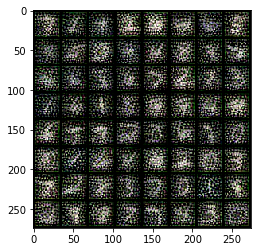

In [33]:
for data in data_loader_test:
    X_test, y_test = data
    print(y_test)
    img = torchvision.utils.make_grid(X_test) 
    img = img.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.show()
    break

In [66]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(            
            nn.Conv2d(3, 6, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),            
        )
        self.classifier = nn.Sequential(
            nn.Linear(576, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),            
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
print(LeNet())

LeNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [67]:
def get_device():
    cuda =  torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    print('use: %s' % str(device))
    return device

In [ ]:
device = get_device()
model = LeNet().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    for data in data_loader_train:
        X_train, y_train = data
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train) 
        pred = torch.max(outputs.data, 1)[1]
        optimizer.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0].item()
        running_correct += torch.sum(pred==y_train.data).item()
    testing_correct = 0
    for data in data_loader_test:
        X_test, y_test = data
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        pred = torch.max(outputs.data, 1)[1]
        testing_correct += torch.sum(pred==y_test.data).item()
    print('epoch: %s' % (str(epoch + 1)))
    print('loss: %s' % str(running_loss / len(data_train)))
    print('training accuracy: %s' % str(running_correct / len(data_train)))
    print('testing accracy: %s' % str(testing_correct / len(data_test))) 
    print()

/Users/DannyShau/anaconda/envs/py3.6/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch: 1
loss: 0.00913824219442904
training accuracy: 0.8078833333333333
testing accracy: 0.9198

epoch: 2
loss: 0.003510438328795135
training accuracy: 0.9294833333333333
testing accracy: 0.942

epoch: 3
loss: 0.002709644586717089
training accuracy: 0.94545
testing accracy: 0.9538

epoch: 4
loss: 0.0022648125007748605
training accuracy: 0.9537166666666667
testing accracy: 0.9501

epoch: 5
loss: 0.0018725832470382253
training accuracy: 0.9614666666666667
testing accracy: 0.963

epoch: 6
loss: 0.0016433244697749614
training accuracy: 0.96615
testing accracy: 0.9622

epoch: 7
loss: 0.0014106004916752378
training accuracy: 0.9713833333333334
testing accracy: 0.9606

epoch: 8
loss: 0.0012563049801935751
training accuracy: 0.9738333333333333
testing accracy: 0.9692

